In [180]:
import numpy as np
import matplotlib.pyplot as plt

# Part 1

### Importing Blosum 50

In [181]:
# Read the BLOSUM50 table
blosum50 = {}
lines = open('blosum50.txt', "rt").readlines()
alpha = lines[0].replace('-', ' ').rstrip('\n\r').split()
for row in lines[1:]:
    row = row.rstrip('\n\r').split()
    alpha1 = row[0]
    for alpha2, score in zip(alpha, row[1:]):
        blosum50[(alpha1, alpha2)] = int(score)
#print(blosum50)

### 1. Implementing Needleman-Wunsch for proteins

In [182]:
# Create an empty matrix
def create_matrix(m, n):
    return [[0]*n for _ in list(range(m))]

def needleman_wunsch(seq1, seq2, blosum, penalty):
 
    m = len(seq1) + 1
    n = len(seq2) + 1
 
    M = create_matrix(m, n)
    
    # Initialize the first row and column
    for i in range(0, m):
        M[i][0] = i * penalty
    for j in range(0, n):
        M[0][j] = j * penalty
    
    # Fill in the matrix
    for i in range(1, m):
        for j in range(1, n):
            match = M[i-1][j-1] + blosum[(seq1[i-1], seq2[j-1])]
            delete = M[i-1][j] + penalty
            insert = M[i][j-1] + penalty
            M[i][j] = max(match, delete, insert)
 
    return M

# Traceback to find the best alignment path
def traceback(seq1, seq2, blosum, penalty, M):
    aligned_seq1 = ''
    aligned_seq2 = ''
    i = len(seq1)
    j = len(seq2)
    
    while i > 0 or j > 0:
        if i > 0 and j > 0 and M[i][j] == M[i-1][j-1] + blosum[(seq1[i-1], seq2[j-1])]:
            # Match or mismatch
            aligned_seq1 = seq1[i-1] + aligned_seq1
            aligned_seq2 = seq2[j-1] + aligned_seq2
            i -= 1
            j -= 1
        elif i > 0 and M[i][j] == M[i-1][j] + penalty:
            # Gap in seq2
            aligned_seq1 = seq1[i-1] + aligned_seq1
            aligned_seq2 = '-' + aligned_seq2
            i -= 1
        else:
            # Gap in seq1
            aligned_seq1 = '-' + aligned_seq1
            aligned_seq2 = seq2[j-1] + aligned_seq2
            j -= 1
    
    return aligned_seq1, aligned_seq2

### 2. Checking it works using HEAGAWGHEE versus PAWHEAE

In [183]:
penalty = -8
sequence1 = 'PAWHEAE'
sequence2 = 'HEAGAWGHEE'

needleman_result = needleman_wunsch(sequence1, sequence2, blosum50, penalty)
print("Alignment score matrix:")
for row in needleman_result:
    print(row)

aligned_seq1, aligned_seq2 = traceback(sequence1, sequence2, blosum50, penalty, needleman_result)
print("Aligned Sequence 1:", aligned_seq1)
print("Aligned Sequence 2:", aligned_seq2)

Alignment score matrix:
[0, -8, -16, -24, -32, -40, -48, -56, -64, -72, -80]
[-8, -2, -9, -17, -25, -33, -41, -49, -57, -65, -73]
[-16, -10, -3, -4, -12, -20, -28, -36, -44, -52, -60]
[-24, -18, -11, -6, -7, -15, -5, -13, -21, -29, -37]
[-32, -14, -18, -13, -8, -9, -13, -7, -3, -11, -19]
[-40, -22, -8, -16, -16, -9, -12, -15, -7, 3, -5]
[-48, -30, -16, -3, -11, -11, -12, -12, -15, -5, 2]
[-56, -38, -24, -11, -6, -12, -14, -15, -12, -9, 1]
Aligned Sequence 1: --P-AW-HEAE
Aligned Sequence 2: HEAGAWGHE-E


### 3. Comparing to lecture slide

<img src="matching.png" width=778 height=514 />

### 4. Matching SALPQPTTPVSSFTSGSMLGRTDTALTNTYSAL with PSPTMEAVTSVEASTASHPHSTSSYFATTYYHLY

In [184]:
penalty = -8
sequence1 = 'SALPQPTTPVSSFTSGSMLGRTDTALTNTYSAL'
sequence2 = 'PSPTMEAVTSVEASTASHPHSTSSYFATTYYHLY'

needleman_result = needleman_wunsch(sequence1, sequence2, blosum50, penalty)
#print("Alignment score matrix:")
#for row in needleman_result:
#    print(row)
    
aligned_seq1, aligned_seq2 = traceback(sequence1, sequence2, blosum50, penalty, needleman_result)
print("Aligned Sequence 1:", aligned_seq1)
print("Aligned Sequence 2:", aligned_seq2)

Aligned Sequence 1: -SALPQPTTPVSSFTSGSMLGRTDTALTNTYSAL-
Aligned Sequence 2: PSPTMEAVTSVEA-STASHPHSTSSYFATTYYHLY


# Part 2

### 1. Implementing Smith-Waterman for proteins

In [185]:
def smith_waterman(seq1, seq2, blosum, penalty):
    m = len(seq1) + 1
    n = len(seq2) + 1
    
    M = create_matrix(m, n)
    
    max_score = 0
    max_i, max_j = 0, 0
    
    for i in range(1, m):
        for j in range(1, n):
            match = M[i-1][j-1] + blosum[(seq1[i-1], seq2[j-1])]
            delete = M[i-1][j] + penalty
            insert = M[i][j-1] + penalty
            # Similar to Needleman-Wunsch, but include 0
            M[i][j] = max(0, match, delete, insert)
            
            # Update maximum score and its position
            if M[i][j] > max_score:
                max_score = M[i][j]
                max_i, max_j = i, j
    
    return M, max_i, max_j

def traceback(seq1, seq2, blosum, penalty, M, max_i, max_j):
    aligned_seq1 = ''
    aligned_seq2 = ''
    i = max_i
    j = max_j
    
    while i > 0 and j > 0 and M[i][j] != 0:
        if M[i][j] == M[i-1][j-1] + blosum[(seq1[i-1], seq2[j-1])]:
            # Match or mismatch
            aligned_seq1 = seq1[i-1] + aligned_seq1
            aligned_seq2 = seq2[j-1] + aligned_seq2
            i -= 1
            j -= 1
        elif M[i][j] == M[i-1][j] + penalty:
            # Gap in seq2
            aligned_seq1 = seq1[i-1] + aligned_seq1
            aligned_seq2 = '-' + aligned_seq2
            i -= 1
        else:
            # Gap in seq1
            aligned_seq1 = '-' + aligned_seq1
            aligned_seq2 = seq2[j-1] + aligned_seq2
            j -= 1
    
    return aligned_seq1, aligned_seq2

### 2. Checking it works using HEAGAWGHEE versus PAWHEAE

In [186]:
penalty = -8
sequence1 = 'PAWHEAE'
sequence2 = 'HEAGAWGHEE'

M, max_i, max_j = smith_waterman(sequence1, sequence2, blosum50, penalty)
#print("Alignment score matrix:")
#for row in M:
#    print(row)
print("Maximum alignment score:", M[max_i][max_j])

aligned_seq1, aligned_seq2 = traceback(sequence1, sequence2, blosum50, penalty, M, max_i, max_j)
print("Aligned Sequence 1:", aligned_seq1)
print("Aligned Sequence 2:", aligned_seq2)

Maximum alignment score: 28
Aligned Sequence 1: AW-HE
Aligned Sequence 2: AWGHE


### 3. Comparing to lecture slide

<img src="localmatching.png" width=778 height=514 />

### 4. Finding best local match for MQNSHSGVNQLGGVFVNGRPLPDSTRQKIVELAHSGARPCDISRILQVSNGCVSKILGRY and TDDECHSGVNQLGGVFVGGRPLPDSTRQKIVELAHSGARPCDISRI

In [187]:
penalty = -8
sequence1 = 'TDDECHSGVNQLGGVFVGGRPLPDSTRQKIVELAHSGARPCDISRI'
sequence2 = 'MQNSHSGVNQLGGVFVNGRPLPDSTRQKIVELAHSGARPCDISRILQVSNGCVSKILGRY'

M, max_i, max_j = smith_waterman(sequence1, sequence2, blosum50, penalty)
#print("Alignment score matrix:")
#for row in M:
#    print(row)
#print("Maximum alignment score:", M[max_i][max_j])

aligned_seq1, aligned_seq2 = traceback(sequence1, sequence2, blosum50, penalty, M, max_i, max_j)
print("Aligned Sequence 1:", aligned_seq1)
print("Aligned Sequence 2:", aligned_seq2)

Aligned Sequence 1: HSGVNQLGGVFVGGRPLPDSTRQKIVELAHSGARPCDISRI
Aligned Sequence 2: HSGVNQLGGVFVNGRPLPDSTRQKIVELAHSGARPCDISRI


# Part 3

### 1. Implementing HMM to mimic dishonest casino

In [188]:
class HMM:
    def __init__(self, states, observations, transition_prob, emission_prob, initial_prob):
        self.states = states
        self.observations = observations
        self.transition_prob = transition_prob
        self.emission_prob = emission_prob
        self.initial_prob = initial_prob

    def generate_sequence(self, length):
        state_sequence = [np.random.choice(self.states, p=[self.initial_prob[state] for state in self.states])]
        observation_sequence = [np.random.choice(self.observations, p=self.emission_prob[state_sequence[0]])]

        for _ in range(length - 1):
            current_state = state_sequence[-1]
            next_state = np.random.choice(self.states, p=self.transition_prob[current_state])
            state_sequence.append(next_state)
            observation_sequence.append(np.random.choice(self.observations, p=self.emission_prob[next_state]))

        return state_sequence, observation_sequence

### 2. Producing human readable output

In [189]:
# Define states:
states = ['F', 'L']

# Define observations:
observations = ['1', '2', '3', '4', '5', '6']

# Transition probabilities:
transition_prob = {'F': [9/10, 1/10], 'L': [1/10, 9/10]}

# Emission probabilities:
emission_prob = {'F': [1/6, 1/6, 1/6, 1/6, 1/6, 1/6], 'L': [1/10, 1/10, 1/10, 1/10, 1/10, 1/2]}

# Initial state probabilities: Assume fair start
initial_prob = {'F': 1, 'L': 0}

# Create the HMM
hmm = HMM(states, observations, transition_prob, emission_prob, initial_prob)

# Generate a sequence
sequence_length = 20
state_sequence, observation_sequence_casino = hmm.generate_sequence(sequence_length)

print("Observation sequence:", observation_sequence_casino)
print("State sequence:      ", state_sequence)

Observation sequence: ['3', '1', '4', '4', '1', '6', '6', '2', '6', '3', '6', '2', '6', '6', '6', '3', '6', '5', '1', '4']
State sequence:       ['F', 'F', 'F', 'F', 'F', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'F', 'F', 'F']


### 3. Comparing with slide

<img src="markov.png" width=778 height=514 />

### 4. Implementing HMM to generate DNA along the model (below)

<img src="model.png" />

#### Generating a 2000 long base sequence

In [198]:
# Define states:
states = ['AT Rich', 'CG Rich']

# Define observations:
observations = ['A', 'T', 'C', 'G']

# Transition probabilities:
transition_prob = {'AT Rich': [0.9997, 0.0003], 'CG Rich': [0.0002, 0.9998]}

# Emission probabilities:
emission_prob = {'AT Rich': [0.2698, 0.3297, 0.2020, 0.1985], 'CG Rich': [0.2459, 0.2079, 0.2478, 0.2984]}

# Initial state probabilities: Assume fair start
initial_prob = {'AT Rich': 0.5, 'CG Rich': 0.5}

# Create the HMM
hmm = HMM(states, observations, transition_prob, emission_prob, initial_prob)

# Generate a sequence
sequence_length = 2000
state_sequence, observation_sequence_dna = hmm.generate_sequence(sequence_length)

### 5. Displaying series

TCTGTCCAGATTATGATTTGAGTTCAGTTTAAAGGTCAACAGTATAGAGATTCAAGCGAGGAGGAACTGGACGCATCTCCACGTACCTGGGCTTTATATTGATATTAATGATACATCTGCCCGTAGCATTTTAAGAGCTGCTCTTATTCCTTTCCTTATCCCCGACGGACTTAAACCTGTTCAAGTACGTCTTTTCACTTCTTGTATAAGACCCTGCGGAACACGCTGCTTCATCCTGGCTTTAGGGCACCGTGATATTCCTTAAAGATTGCCTCTTGTAATATTTATGTTATCGTTCGGAGCTATCATAAGTGTAACTATACTCGTATATCGATCCATACTCCCGATATTGTATGCCGAACCCATCCTTTTCTGTATACTTTGTTGGGCTTGTTCCTCTTTACGTAACACAAGCAATAGAACATTATACGTGATCAAAGAGAATCTAGCCACGCTTGCCGGACACCGTCCAAACCCGTTTCCGGGCCACCTACGACAAACAGGTCTGATCTGCTAGATCACTCCGGAGTGAAGGACAATACCCGAGGTTCGATTTAAGGCTAAAGTTACGGTCGGTATGAACTTGGTGGCACCAGCGTGTGCTGGGGGGAATTCGATTTCAGCGGACCACGACGGTCACGCTACCCACGATGATGGAAGGGTCGTCGTCAATGCTGCATATATGTCCGGGTGCGTCAAACCTTGAGCCTTGATGCAGTCAGAATTTGGGAAAAAATCCAGAGCTATATGACGCTGGGGGCCGCGACCCGAGCACCACGAGACGTGGACGCCACATTAGGGGGTTGCGCAATAATGTCCAGTTTACGGTCAGAGGTTCCACAACCACTACAGGGGCCGTATATTGCGCGCTACACAAGGCACACGTACCGAGAGCGAGTAATTCCCTGAGGAAGGGCTGAAAAGGCGACCGGGAAAATGCAACTCGGACTGTGATTCCTGGTCAAGTGTTCCGGCTAGGAGCGGGATCAAACCCGGGGGG

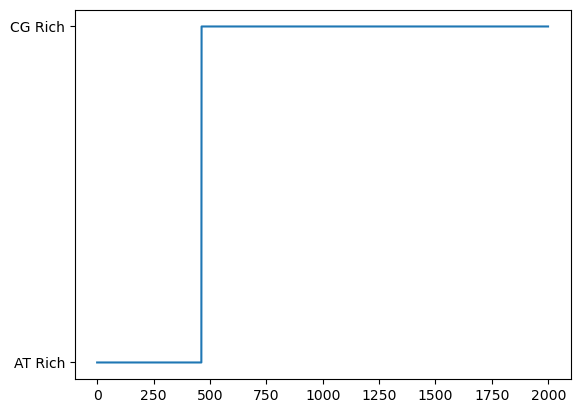

In [199]:
# Display the sequence
# print("\nObservation Sequence:")
print("".join([obs for obs in observation_sequence_dna]))

plt.plot(state_sequence)

# Part 4

### 1. Implementing Viterbi for most likely state sequence in HMM

In [192]:
import numpy as np
import matplotlib.pyplot as plt

def viterbi(observations, states, initial_prob, transition_prob, emission_prob):
    # Convert probabilities to logarithms
    initial_prob_log = {state: np.log(prob + 1e-100) for state, prob in initial_prob.items()}
    transition_prob_log = {state: [np.log(p + 1e-100) for p in probs] for state, probs in transition_prob.items()}
    emission_prob_log = {state: {obs: np.log(prob + 1e-100) for obs, prob in probs.items()} for state, probs in emission_prob.items()}
    
    trellis = np.zeros((len(states), len(observations)))
    backpointers = np.zeros((len(states), len(observations)), dtype=int)
    
    posterior_probs_over_time = []
    
    trellis[:, 0] = [initial_prob_log[state] + emission_prob_log[state][observations[0]] for state in states]
    
    # Recursively fill the trellis
    for t in range(1, len(observations)):
        for s in range(len(states)):
            max_prob = -np.inf
            max_prob_index = -1
            for s_prev in range(len(states)):
                prob = trellis[s_prev, t-1] + transition_prob_log[states[s_prev]][s] + emission_prob_log[states[s]][observations[t]]
                if prob > max_prob:
                    max_prob = prob
                    max_prob_index = s_prev
            trellis[s, t] = max_prob
            backpointers[s, t] = max_prob_index
        
        # Calculate posterior probability
        posterior_prob_t = np.max(trellis[:, t])
        posterior_probs_over_time.append(np.exp(posterior_prob_t - np.log(len(observations))))
    
    # Traceback
    best_path_prob = np.max(trellis[:, -1])
    best_path_pointer = np.argmax(trellis[:, -1])
    best_path = [best_path_pointer]
    for t in range(len(observations)-1, 0, -1):
        best_path_pointer = backpointers[best_path_pointer, t]
        best_path.insert(0, best_path_pointer)
    
    # Calculate posterior probability
    posterior_prob = np.exp(best_path_prob - np.log(len(observations)))
    
    return best_path, posterior_prob, posterior_probs_over_time

### 2. Testing on dishonest casino and DNA sequence generator

Best path: ['F', 'F', 'F', 'F', 'F', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L']
Posterior probability: 3.769979225365951e-17


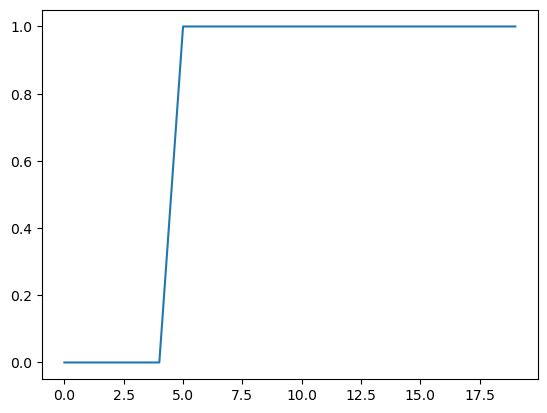

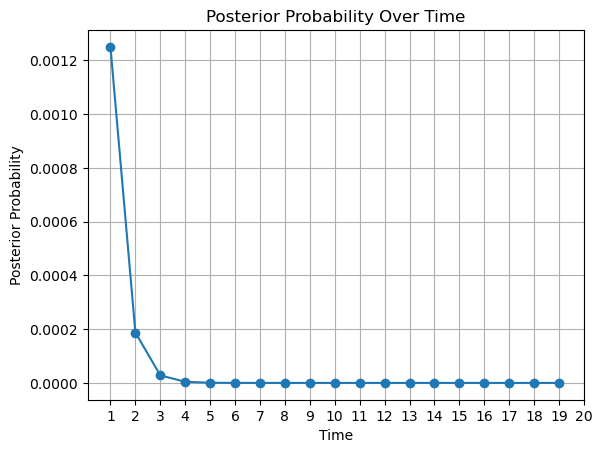

In [201]:
states = ['F', 'L']
initial_prob = {'F': 1, 'L': 0}
transition_prob = {'F': [9/10, 1/10], 'L': [1/10, 9/10]}
emission_prob = {'F': {'1': 1/6, '2': 1/6, '3': 1/6, '4': 1/6, '5': 1/6, '6': 1/6}, 'L': {'1': 1/10, '2': 1/10, '3': 1/10, '4': 1/10, '5': 1/10, '6': 1/2}}

best_path, posterior_prob, posterior_probs_over_time = viterbi(observation_sequence_casino, states, initial_prob, transition_prob, emission_prob)
print("Best path:", [states[i] for i in best_path])
print("Posterior probability:", posterior_prob)

plt.plot(best_path)
plt.show()

plt.plot(range(1, len(observation_sequence_casino)), posterior_probs_over_time, marker='o')
plt.xlabel('Time')
plt.ylabel('Posterior Probability')
plt.title('Posterior Probability Over Time')
plt.xticks(range(1, len(observation_sequence_casino) + 1))
plt.grid(True)
plt.show()

Posterior probability: 0.0


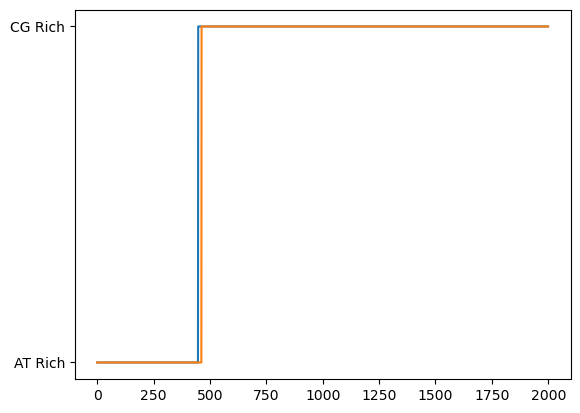

In [200]:
# Define states:
states = ['AT Rich', 'CG Rich']

# Define observations:
observations = ['A', 'T', 'C', 'G']

# Transition probabilities:
transition_prob = {'AT Rich': [0.9997, 0.0003], 'CG Rich': [0.0002, 0.9998]}

# Emission probabilities:
emission_prob = {'AT Rich': {'A': 0.2698, 'T': 0.3297, 'C': 0.2020, 'G': 0.1985}, 'CG Rich': {'A': 0.2459, 'T': 0.2079, 'C': 0.2478, 'G': 0.2984}}

# Initial state probabilities:
initial_prob = {'AT Rich': 0.5, 'CG Rich': 0.5}

best_path, posterior_prob, posterior_probs_over_time = viterbi(observation_sequence_dna, states, initial_prob, transition_prob, emission_prob)
# print("Best path:", [states[i] for i in best_path])
print("Posterior probability:", posterior_prob)

plt.plot(best_path)
plt.plot(state_sequence)

plt.show()

### 3. Running on lambda phage genome

Probability of the most likely state sequence: 0.0


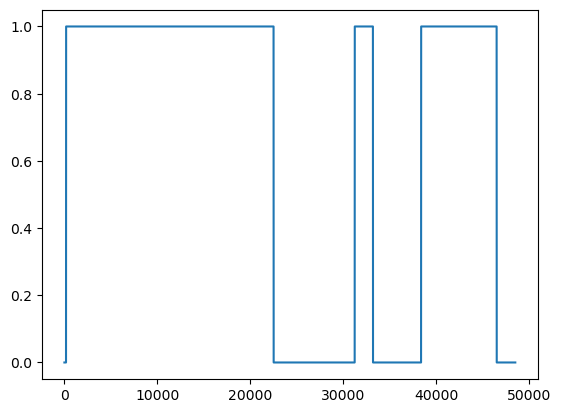

In [195]:
with open('enteriobacteriophage.txt', 'r') as file:
    dna_data = file.read()
    dna_data = dna_data.replace('\n', '')

# Viterbi
best_path, best_path_prob, posterior_prob = viterbi(dna_data, states, initial_prob, transition_prob, emission_prob)

# Display the result
# print("Sequence:", dna_data)
# print("Most likely state sequence:", [states[i] for i in best_path])
print("Probability of the most likely state sequence:", best_path_prob)

plt.plot(best_path)

Comments: posterior probability is most likely wrong but Viterbi seems correct. Tried to implement the forward-backward algorithm unsuccessfully.